<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-Setup" data-toc-modified-id="Code-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code Setup</a></span><ul class="toc-item"><li><span><a href="#Acronyms-and-abbreviations" data-toc-modified-id="Acronyms-and-abbreviations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Acronyms and abbreviations</a></span></li></ul></li><li><span><a href="#Establish-Data-Frames" data-toc-modified-id="Establish-Data-Frames-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Establish Data Frames</a></span><ul class="toc-item"><li><span><a href="#Read-in-feature-data" data-toc-modified-id="Read-in-feature-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read in feature data</a></span></li><li><span><a href="#Read-in-WF-data" data-toc-modified-id="Read-in-WF-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Read in WF data</a></span></li><li><span><a href="#Data-frames" data-toc-modified-id="Data-frames-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Data frames</a></span><ul class="toc-item"><li><span><a href="#1:200-ENM-organics-data" data-toc-modified-id="1:200-ENM-organics-data-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>1:200 ENM-organics data</a></span></li><li><span><a href="#1:100-ENM-organics-data" data-toc-modified-id="1:100-ENM-organics-data-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>1:100 ENM-organics data</a></span></li><li><span><a href="#1:50-ENM-organics-data" data-toc-modified-id="1:50-ENM-organics-data-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>1:50 ENM-organics data</a></span></li><li><span><a href="#1:20-ENM-organics-data" data-toc-modified-id="1:20-ENM-organics-data-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>1:20 ENM-organics data</a></span></li><li><span><a href="#1:10-ENM-organics-data" data-toc-modified-id="1:10-ENM-organics-data-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>1:10 ENM-organics data</a></span></li><li><span><a href="#1:4-ENM-organics-data" data-toc-modified-id="1:4-ENM-organics-data-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>1:4 ENM-organics data</a></span></li><li><span><a href="#1:2-ENM-organics-data" data-toc-modified-id="1:2-ENM-organics-data-2.3.7"><span class="toc-item-num">2.3.7&nbsp;&nbsp;</span>1:2 ENM-organics data</a></span></li><li><span><a href="#Apply-WF-bins" data-toc-modified-id="Apply-WF-bins-2.3.8"><span class="toc-item-num">2.3.8&nbsp;&nbsp;</span>Apply WF bins</a></span></li><li><span><a href="#Matching-1:20-ENM-organics" data-toc-modified-id="Matching-1:20-ENM-organics-2.3.9"><span class="toc-item-num">2.3.9&nbsp;&nbsp;</span>Matching 1:20 ENM-organics</a></span></li><li><span><a href="#Matching-1:10-ENM-organics" data-toc-modified-id="Matching-1:10-ENM-organics-2.3.10"><span class="toc-item-num">2.3.10&nbsp;&nbsp;</span>Matching 1:10 ENM-organics</a></span></li><li><span><a href="#Matching-1:5-ENM-organics" data-toc-modified-id="Matching-1:5-ENM-organics-2.3.11"><span class="toc-item-num">2.3.11&nbsp;&nbsp;</span>Matching 1:5 ENM-organics</a></span></li><li><span><a href="#Matching-1:4-ENM-organics" data-toc-modified-id="Matching-1:4-ENM-organics-2.3.12"><span class="toc-item-num">2.3.12&nbsp;&nbsp;</span>Matching 1:4 ENM-organics</a></span></li><li><span><a href="#Matching-1:3-ENM-organics" data-toc-modified-id="Matching-1:3-ENM-organics-2.3.13"><span class="toc-item-num">2.3.13&nbsp;&nbsp;</span>Matching 1:3 ENM-organics</a></span></li><li><span><a href="#Matching-1:2-ENM-organics" data-toc-modified-id="Matching-1:2-ENM-organics-2.3.14"><span class="toc-item-num">2.3.14&nbsp;&nbsp;</span>Matching 1:2 ENM-organics</a></span></li></ul></li></ul></li><li><span><a href="#SVC-Models" data-toc-modified-id="SVC-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SVC Models</a></span><ul class="toc-item"><li><span><a href="#ENM-only" data-toc-modified-id="ENM-only-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ENM only</a></span></li><li><span><a href="#Essentially-leave-one-out-cross-validation,-slight-biases,-might-be-overfitting" data-toc-modified-id="Essentially-leave-one-out-cross-validation,-slight-biases,-might-be-overfitting-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Essentially leave one out cross validation, slight biases, might be overfitting</a></span></li><li><span><a href="#1:200-ENM-organics-data" data-toc-modified-id="1:200-ENM-organics-data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>1:200 ENM-organics data</a></span></li><li><span><a href="#1:100-ENM-organics-data" data-toc-modified-id="1:100-ENM-organics-data-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>1:100 ENM-organics data</a></span></li><li><span><a href="#1:50-ENM-organics-data" data-toc-modified-id="1:50-ENM-organics-data-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>1:50 ENM-organics data</a></span></li><li><span><a href="#1:20-ENM-organics-data" data-toc-modified-id="1:20-ENM-organics-data-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>1:20 ENM-organics data</a></span></li><li><span><a href="#1:10-ENM-organics-data" data-toc-modified-id="1:10-ENM-organics-data-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>1:10 ENM-organics data</a></span></li><li><span><a href="#1:4-ENM-organics-data" data-toc-modified-id="1:4-ENM-organics-data-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>1:4 ENM-organics data</a></span></li><li><span><a href="#1:2-ENM-organics-data" data-toc-modified-id="1:2-ENM-organics-data-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>1:2 ENM-organics data</a></span></li><li><span><a href="#Matching-1:20" data-toc-modified-id="Matching-1:20-3.10"><span class="toc-item-num">3.10&nbsp;&nbsp;</span>Matching 1:20</a></span></li><li><span><a href="#Matching-1:10" data-toc-modified-id="Matching-1:10-3.11"><span class="toc-item-num">3.11&nbsp;&nbsp;</span>Matching 1:10</a></span></li><li><span><a href="#Matching-1:5" data-toc-modified-id="Matching-1:5-3.12"><span class="toc-item-num">3.12&nbsp;&nbsp;</span>Matching 1:5</a></span></li><li><span><a href="#Matching-1:4" data-toc-modified-id="Matching-1:4-3.13"><span class="toc-item-num">3.13&nbsp;&nbsp;</span>Matching 1:4</a></span></li><li><span><a href="#Matching-1:3" data-toc-modified-id="Matching-1:3-3.14"><span class="toc-item-num">3.14&nbsp;&nbsp;</span>Matching 1:3</a></span></li><li><span><a href="#Matching-1:2" data-toc-modified-id="Matching-1:2-3.15"><span class="toc-item-num">3.15&nbsp;&nbsp;</span>Matching 1:2</a></span></li><li><span><a href="#Augmentation-Performance" data-toc-modified-id="Augmentation-Performance-3.16"><span class="toc-item-num">3.16&nbsp;&nbsp;</span>Augmentation Performance</a></span></li></ul></li><li><span><a href="#Random-Forest-Models" data-toc-modified-id="Random-Forest-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random Forest Models</a></span></li></ul></div>

Summary of changes since 12/17:
* Added more data frames for matching augmentation
* Restructured data frames based on same random state, but shuffled (so that the organics rows or "tuples" are sampled from the previous df for dfs of increasing ENM:organics ratios)
* Also rewrote dfs so bins are applied after label dfs are established; this will make it easier for future models that use continuous wf labels
* Finished graph of performance vs % of augmentation with organics data
* Updated acronyms

# Code Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "BLTfigs"

In [5]:
import os
#os.chdir(path)
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [6]:
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf')

In [7]:
# To enable a specified sound to play
from IPython.display import Audio
sound_file = './data/Glass.wav'

# Add the following to the end of a cell with a long run time
# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

In [8]:
# Shift tab to understand function components
# Type questionmark before function to bring up help

## Acronyms and abbreviations

* arr = array
* bp = boiling point
* df = dataframe
* enm = engineered nanomaterial
* matrix_F = matrix of the product is a formulation (i.e., not a solid)
* mp = melting point
* mw = molecular weight
* oecd = Organisation for Economic Co-operation and Development
* prop = property
* PUC = product use category
* wf = weight fraction

# Establish Data Frames

## Read in feature data

In [10]:
# Target (ENM) model data
X_enm = pd.read_csv("./data/XX_enm.csv", sep='\t', header='infer', index_col=0)
X_enm.head(4)

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
0,79.867,1843.00,2972.0,0.626340,0.5,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
1,63.546,1083.00,2567.0,0.952308,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,65.370,419.53,907.0,0.853698,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,107.868,961.78,2162.0,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1


In [11]:
# Source (organics) model data
X_source = pd.read_csv("./data/XX_source.csv", sep='\t', header='infer', index_col=0)
X_source.head(4)

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
1,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1
4,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1


In [12]:
print(X_source.shape)

(16354, 39)


## Read in WF data

In [20]:
# Read in ENM maximum_weight_fraction data
y_enm = pd.read_csv("./data/ENM_conc_export.csv", sep=',', header='infer', usecols=[3])

In [21]:
# Read in organics maximum_weight_fraction data
y_source = pd.read_csv("./data/y_source.csv", sep=',', header='infer')
y_source.index = X_source.index

## Data frames

Multiple data frames are constructed for testing models with varying ratios of ENM:organics data.

### 1:200 ENM-organics data

In [22]:
# ENM and all organics data stacked, respectively
X_all = pd.concat([X_enm, X_source], sort=False)
y_all = pd.concat([y_enm, y_source])

print(X_all.shape)
print(y_all.shape)

(16436, 39)
(16436, 1)


In [24]:
X_all.tail(4)

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
29366,152.149,84.03215,263.941,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
29367,152.149,84.03215,263.941,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
29368,135.210,-31.78080,203.080,-0.031517,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
29369,135.210,-31.78080,203.080,-0.031517,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
y_all.tail(4)

,maximum_weight_fraction
29366,0.01
29367,0.01
29368,0.02
29369,0.02


### 1:100 ENM-organics data

In [31]:
# Randomly sample 50% of organics data
X_oneto100 = X_source.sample(n=8200, replace=False, random_state=38, axis=0)
idx = X_oneto100.index.tolist()

y_oneto100 = pd.DataFrame(y_source)
y_oneto100 = y_oneto100.loc[idx]

print(X_oneto100.shape)
print(y_oneto100.shape)

(8200, 39)
(8200, 1)


In [32]:
X_oneto100.head(5)

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
25664,72.107,-66.158800,78.8506,-0.057000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1
2567,270.457,3.531835,303.6770,-0.078834,0.0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
2702,104.149,-10.558055,222.9220,0.009451,0.0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
26742,222.240,11.436800,303.6145,0.045323,0.0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
18760,188.183,165.501000,285.0290,0.143327,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
y_oneto100.head(5)

,maximum_weight_fraction
25664,0.050
2567,0.046
2702,0.150
26742,0.050
18760,0.003


In [34]:
# Append sampled organics data to ENM data
X_oneto100 = pd.concat([X_enm, X_oneto100], sort=False)
y_oneto100 = pd.concat([y_enm, y_oneto100], sort=False)

print(X_oneto100.shape)
print(y_oneto100.shape)

(8282, 39)
(8282, 1)


In [35]:
X_oneto100.iloc[80:85,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.000000,2972.0000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.780000,2162.0000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
25664,72.107,-66.158800,78.8506,-0.057000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1
2567,270.457,3.531835,303.6770,-0.078834,0.0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
2702,104.149,-10.558055,222.9220,0.009451,0.0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
y_oneto100.iloc[80:85,:]

,maximum_weight_fraction
80,0.000667
81,0.000800
25664,0.050000
2567,0.046000
2702,0.150000


### 1:50 ENM-organics data

In [44]:
# Randomly sample 25% of organics data
X_oneto50 = X_oneto100.iloc[82:,:].sample(frac=0.5, replace=False, random_state=38, axis=0)
y_oneto50 = y_oneto100.iloc[82:,:].sample(frac=0.5, replace=False, random_state=38, axis=0)

print(X_oneto50.shape)
print(y_oneto50.shape)

(4100, 39)
(4100, 1)


In [45]:
# Append sampled organics data to ENM data
X_oneto50 = pd.concat([X_enm, X_oneto50], sort=False)
y_oneto50 = pd.concat([y_enm, y_oneto50], sort=False)

print(X_oneto50.shape)
print(y_oneto50.shape)

(4182, 39)
(4182, 1)


In [46]:
X_oneto50.iloc[80:85,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.0000,2972.00000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.7800,2162.00000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
15775,76.095,-31.9957,180.43000,0.004321,0.5,0.0,0.5,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
19154,60.096,-71.4224,86.55995,-0.063989,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
11118,149.590,107.2720,192.77200,0.135133,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
y_oneto50.iloc[80:85,:]

,maximum_weight_fraction
80,0.000667
81,0.000800
15775,0.150000
19154,0.150000
11118,0.090000


### 1:20 ENM-organics data

In [49]:
# Randomly sample 10% of organics data
X_oneto20 = X_oneto50.iloc[82:,:].sample(n=1640, replace=False, random_state=38, axis=0)
y_oneto20 = y_oneto50.iloc[82:,:].sample(n=1640, replace=False, random_state=38, axis=0)

print(X_oneto20.shape)
print(y_oneto20.shape)

(1640, 39)
(1640, 1)


In [50]:
# Append sampled organics data to ENM data
X_oneto20 = pd.concat([X_enm, X_oneto20], sort=False)
y_oneto20 = pd.concat([y_enm, y_oneto20], sort=False)

print(X_oneto20.shape)
print(y_oneto20.shape)

(1722, 39)
(1722, 1)


In [51]:
X_oneto20.iloc[80:85,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.0000,2972.000000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.7800,2162.000000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
9788,229.408,88.1400,244.263000,0.070813,0.5,0.0,0.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
1688,62.068,-8.4879,172.860500,0.013259,0.5,0.0,0.5,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
22422,58.124,-122.0195,-0.131515,-0.159267,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [52]:
y_oneto20.iloc[80:85,:]

,maximum_weight_fraction
80,0.000667
81,0.000800
9788,0.050000
1688,0.050000
22422,0.980000


### 1:10 ENM-organics data

In [55]:
# Randomly sample 5% of organics data
X_oneto10 = X_oneto20.iloc[82:,:].sample(n=820, replace=False, random_state=38, axis=0)
y_oneto10 = y_oneto20.iloc[82:,:].sample(n=820, replace=False, random_state=38, axis=0)

print(X_oneto10.shape)
print(y_oneto10.shape)

(820, 39)
(820, 1)


In [56]:
# Append sampled organics data to ENM data
X_oneto10 = pd.concat([X_enm, X_oneto10], sort=False)
y_oneto10 = pd.concat([y_enm, y_oneto10], sort=False)

print(X_oneto10.shape)
print(y_oneto10.shape)

(902, 39)
(902, 1)


### 1:4 ENM-organics data

In [62]:
# Randomly sample 2% of organics data
X_oneto4 = X_oneto10.iloc[82:,:].sample(n=328, replace=False, random_state=38, axis=0)
y_oneto4 = y_oneto10.iloc[82:,:].sample(n=328, replace=False, random_state=38, axis=0)

print(X_oneto4.shape)
print(y_oneto4.shape)

(328, 39)
(328, 1)


In [63]:
# Append sampled organics data to ENM data
X_oneto4 = pd.concat([X_enm, X_oneto4], sort=False)
y_oneto4 = pd.concat([y_enm, y_oneto4], sort=False)

print(X_oneto4.shape)
print(y_oneto4.shape)

(410, 39)
(410, 1)


### 1:2 ENM-organics data

In [64]:
# Randomly sample 1% of organics data
X_oneto2 = X_oneto10.iloc[82:,:].sample(n=164, replace=False, random_state=38, axis=0)
y_oneto2 = y_oneto10.iloc[82:,:].sample(n=164, replace=False, random_state=38, axis=0)

print(X_oneto2.shape)
print(y_oneto2.shape)

(164, 39)
(164, 1)


In [65]:
# Append sampled organics data to ENM data
X_oneto2 = pd.concat([X_enm, X_oneto2], sort=False)
y_oneto2 = pd.concat([y_enm, y_oneto2], sort=False)

print(X_oneto2.shape)
print(y_oneto2.shape)

(246, 39)
(246, 1)


### Apply WF bins

In [92]:
# Define function to assign weight fractions to bins 
# (different from those used by Isaacs et al. 2016)
def bins(row):
    if row['maximum_weight_fraction'] <= 0.002:
        val = 'bottom'
    elif row['maximum_weight_fraction'] > 0.05:
        val = 'top'
    else:
        val = 'middle'
    return val

Text(0.5,1,'Frequency of ENM Weight Fraction Bins')

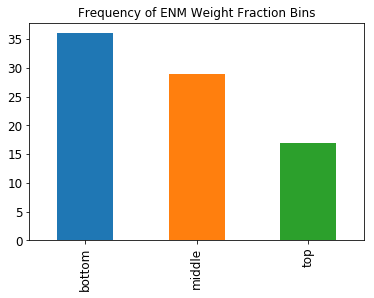

In [93]:
# Apply bins to ENM labels
bin_enm = y_enm.apply(bins, axis=1)
# View histogram of bins
bin_enm.value_counts().plot(kind='bar')
plt.title('Frequency of ENM Weight Fraction Bins')

In [94]:
# Use label encoder to make bins compatible with Scikit-Learn
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Fit the encoder and transform categories into integers
bin_enm = le.fit_transform(bin_enm)

Do the same for the organics WF data.

Text(0.5,1,'Frequency of Organics Weight Fraction Bins')

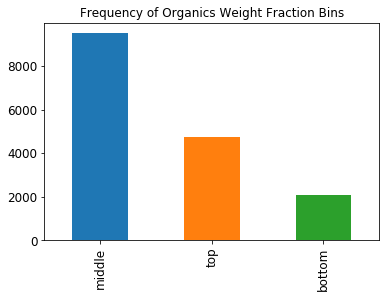

In [95]:
# Apply bins, label encoder to organics labels
bin_source = y_source.apply(bins, axis=1)
# View histogram of bins
bin_source.value_counts().plot(kind='bar')
plt.title('Frequency of Organics Weight Fraction Bins')

In [96]:
# Apply bins, label encoder to source WF data
bin_source = y_source.apply(bins, axis=1)
bin_source = le.fit_transform(bin_source)

print(bin_source.shape)
print(type(bin_source))

(16354,)
<class 'numpy.ndarray'>


Do the same for the ENM:organics WF dfs.

In [98]:
# Apply bins, label encoder to all other WF data frames

# bin_all
bin_all = y_all.apply(bins, axis=1)
bin_all = le.fit_transform(bin_all)
#bin_all = bin_all.values.ravel()
print(bin_all.shape)

# bin_oneto100
bin_oneto100 = y_oneto100.apply(bins, axis=1)
bin_oneto100 = le.fit_transform(bin_oneto100)
#bin_oneto100 = bin_oneto100.values.ravel()
print(bin_oneto100.shape)

# bin_oneto50
bin_oneto50 = y_oneto50.apply(bins, axis=1)
bin_oneto50 = le.fit_transform(bin_oneto50)
#bin_oneto50 = bin_oneto50.values.ravel()
print(bin_oneto50.shape)

# bin_oneto20
bin_oneto20 = y_oneto20.apply(bins, axis=1)
bin_oneto20 = le.fit_transform(bin_oneto20)
#bin_oneto20 = bin_oneto20.values.ravel()
print(bin_oneto20.shape)

# bin_oneto10
bin_oneto10 = y_oneto10.apply(bins, axis=1)
bin_oneto10 = le.fit_transform(bin_oneto10)
#bin_oneto10 = bin_oneto10.values.ravel()
print(bin_oneto10.shape)

# bin_oneto4
bin_oneto4 = y_oneto4.apply(bins, axis=1)
bin_oneto4 = le.fit_transform(bin_oneto4)
#bin_oneto4 = bin_oneto4.values.ravel()
print(bin_oneto4.shape)

# bin_oneto2
bin_oneto2 = y_oneto2.apply(bins, axis=1)
bin_oneto2 = le.fit_transform(bin_oneto2)
#bin_oneto2 = bin_oneto2.values.ravel()
print(bin_oneto2.shape)

(16436,)
(8282,)
(4182,)
(1722,)
(902,)
(410,)
(246,)


In [100]:
# Check distribution across WF bins
unique, counts = np.unique(bin_oneto100, return_counts=True)
dict(zip(unique, counts))

{0: 1096, 1: 4776, 2: 2410}

### Matching 1:20 ENM-organics

Instead of randomly selecting organics "tuples" to use for augmentation, the _kth_ closest tuples to each ENM tuple were selected based on cosine distance, or _1 - cosine similarity_.

* https://stackoverflow.com/questions/34226400/find-the-index-of-the-k-smallest-values-of-a-numpy-array
* https://stackoverflow.com/questions/22117834/how-do-i-return-a-list-of-the-3-lowest-values-in-another-list
* http://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html

In [225]:
# Scale/normalize data for computing distance
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_enm_scaled = pd.DataFrame(scaler.fit_transform(X_enm), 
                            columns = X_enm.columns, 
                            index = X_enm.index)
X_source_scaled = pd.DataFrame(scaler.fit_transform(X_source),
                             columns = X_source.columns,
                             index = X_source.index)

In [226]:
# Cosine similarity computes the L2-normalized dot product of vectors
# Cosine distance = 1 - cosine similarity
from sklearn.metrics.pairwise import cosine_distances

cosdist = cosine_distances(X = X_source_scaled, 
                    Y = X_enm_scaled)
print(cosdist.shape)

(16354, 82)


In [227]:
# Write loop to match most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 20

# Define function to get indices of k smallest distances
def smallest(X, k): 
    matches = np.argpartition(X, k-1)[:k]
    return matches

# Loop over cosdist "matrix" to return list of matching organics indices
idx_match = []
dist_match = []
for col in cosdist.T:
    # Find indices of k-smallest distances
    matches = smallest(col,k)
    idx_match.extend(matches)
    dist_match.extend(col[matches])

In [230]:
# Abbreviated table of matching organics indices and their cosine distance from an ENM tuple
match_table = pd.DataFrame({
    'organic_idx': idx_match, 
    'cosdist': dist_match})
match_table.head(20)

,organic_idx,cosdist
0,11243,0.266205
1,56,0.292110
2,39,0.292110
3,15327,0.280466
4,15326,0.280466
5,15322,0.190294
6,15321,0.280466
7,15320,0.280466
8,15318,0.280466
9,15315,0.190294


In [229]:
match_table.tail(20)

,organic_idx,cosdist
1620,5070,0.198167
1621,8421,0.199043
1622,8515,0.199043
1623,8402,0.199043
1624,4585,0.175033
1625,6894,0.177384
1626,8563,0.199043
1627,8354,0.199043
1628,5065,0.198167
1629,6918,0.170179


In [105]:
# Create X and y dataframes of matches using the generated index list
X_match20 = X_source.iloc[idx_match]
y_match20 = pd.DataFrame(y_source)
y_match20 = y_match20.iloc[idx_match]

# Append sampled organics data to ENM data
X_match20 = pd.concat([X_enm, X_match20], sort=False)
y_match20 = pd.concat([y_enm, y_match20], sort=False)

# Apply wf bins
bin_match20 = y_match20.apply(bins, axis=1)
bin_match20 = le.fit_transform(bin_match20)

print(X_match20.shape)
print(bin_match20.shape)

(1722, 39)
(1722,)


In [106]:
X_match20.iloc[80:85,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.0000,2972.0000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.7800,2162.0000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
17673,386.364,193.1210,408.0050,0.140194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
57,106.168,-52.5218,147.1505,-0.050610,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
40,106.168,-52.5218,147.1505,-0.050610,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


In [107]:
y_match20.iloc[80:85,:]

,maximum_weight_fraction
80,0.000667
81,0.000800
17673,0.050000
57,0.050000
40,0.200000


In [108]:
# Check distribution across WF bins
unique, counts = np.unique(bin_match20, return_counts=True)
dict(zip(unique, counts))

{0: 232, 1: 1026, 2: 464}

### Matching 1:10 ENM-organics

In [109]:
# Write loop to match most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 10

# Loop over cosdist "matrix" to return list of matching organics indices
idx_match = []
dist_match = []
for col in cosdist.T:
    # Find indices of k-smallest distances
    matches = smallest(col,k)
    idx_match.extend(matches)
    dist_match.extend(col[matches])

In [110]:
# Create X and y dataframes of matches using the generated index list
X_match10 = X_source.iloc[idx_match]
y_match10 = pd.DataFrame(y_source)
y_match10 = y_match10.iloc[idx_match]

# Append sampled organics data to ENM data
X_match10 = pd.concat([X_enm, X_match10], sort=False)
y_match10 = pd.concat([y_enm, y_match10], sort=False)

# Apply wf bins
bin_match10 = y_match10.apply(bins, axis=1)
bin_match10 = le.fit_transform(bin_match10)

print(X_match10.shape)
print(bin_match10.shape)

(902, 39)
(902,)


### Matching 1:5 ENM-organics

In [160]:
# Write loop to match most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 5

# Loop over cosdist "matrix" to return list of matching organics indices
idx_match = []
dist_match = []
for col in cosdist.T:
    # Find indices of k-smallest distances
    matches = smallest(col,k)
    idx_match.extend(matches)
    dist_match.extend(col[matches])

In [161]:
# Create X and y dataframes of matches using the generated index list
X_match5 = X_source.iloc[idx_match]
y_match5 = pd.DataFrame(y_source)
y_match5 = y_match5.iloc[idx_match]

# Append sampled organics data to ENM data
X_match5 = pd.concat([X_enm, X_match5], sort=False)
y_match5 = pd.concat([y_enm, y_match5], sort=False)

# Apply wf bins
bin_match5 = y_match5.apply(bins, axis=1)
bin_match5 = le.fit_transform(bin_match5)

print(X_match5.shape)
print(bin_match5.shape)

(492, 39)
(492,)


### Matching 1:4 ENM-organics

In [112]:
# Write loop to match most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 4

# Loop over cosdist "matrix" to return list of matching organics indices
idx_match = []
dist_match = []
for col in cosdist.T:
    # Find indices of k-smallest distances
    matches = smallest(col,k)
    idx_match.extend(matches)
    dist_match.extend(col[matches])

In [113]:
# Create X and y dataframes of matches using the generated index list
X_match4 = X_source.iloc[idx_match]
y_match4 = pd.DataFrame(y_source)
y_match4 = y_match4.iloc[idx_match]

# Append sampled organics data to ENM data
X_match4 = pd.concat([X_enm, X_match4], sort=False)
y_match4 = pd.concat([y_enm, y_match4], sort=False)

# Apply wf bins
bin_match4 = y_match4.apply(bins, axis=1)
bin_match4 = le.fit_transform(bin_match4)

print(X_match4.shape)
print(bin_match4.shape)

(410, 39)
(410,)


### Matching 1:3 ENM-organics

In [167]:
# Write loop to match most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 3

# Loop over cosdist "matrix" to return list of matching organics indices
idx_match = []
dist_match = []
for col in cosdist.T:
    # Find indices of k-smallest distances
    matches = smallest(col,k)
    idx_match.extend(matches)
    dist_match.extend(col[matches])

In [168]:
# Create X and y dataframes of matches using the generated index list
X_match3 = X_source.iloc[idx_match]
y_match3 = pd.DataFrame(y_source)
y_match3 = y_match3.iloc[idx_match]

# Append sampled organics data to ENM data
X_match3 = pd.concat([X_enm, X_match3], sort=False)
y_match3 = pd.concat([y_enm, y_match3], sort=False)

# Apply wf bins
bin_match3 = y_match3.apply(bins, axis=1)
bin_match3 = le.fit_transform(bin_match3)

print(X_match3.shape)
print(bin_match3.shape)

(328, 39)
(328,)


### Matching 1:2 ENM-organics

In [114]:
# Write loop to match most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 2

# Loop over cosdist "matrix" to return list of matching organics indices
idx_match = []
dist_match = []
for col in cosdist.T:
    # Find indices of k-smallest distances
    matches = smallest(col,k)
    idx_match.extend(matches)
    dist_match.extend(col[matches])

In [115]:
# Create X and y dataframes of matches using the generated index list
X_match2 = X_source.iloc[idx_match]
y_match2 = pd.DataFrame(y_source)
y_match2 = y_match2.iloc[idx_match]

# Append sampled organics data to ENM data
X_match2 = pd.concat([X_enm, X_match2], sort=False)
y_match2 = pd.concat([y_enm, y_match2], sort=False)

# Apply wf bins
bin_match2 = y_match2.apply(bins, axis=1)
bin_match2 = le.fit_transform(bin_match2)

print(X_match2.shape)
print(bin_match2.shape)

(246, 39)
(246,)


# SVC Models

## ENM only

Here I make use of a helper class in order to compare different model estimators with different parameters. Estimator Selection Helper is by David Batista:
http://www.davidsbatista.net/blog/2018/02/23/model_optimization/.

In [116]:
# Set up for grid search across multiple pipelines
from sklearn.model_selection import GridSearchCV

cv=10
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=cv, n_jobs=1, verbose=1, scoring='accuracy', refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [117]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=10
models = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

params = {
    'RandomForest': { 'n_estimators': [10,12,14,16,18,20]},
    'SVC': [
        {'kernel': ['linear'], 'C': np.logspace(0,5,10)},
        {'kernel': ['rbf'], 'C': np.logspace(0,5,10), 'gamma': np.logspace(-6,0,10)},
    ]
}

In [118]:
# Fit gridsearch models to select best estimator
helper = EstimatorSelectionHelper(models, params)
helper.fit(X_enm_scaled, bin_enm, n_jobs=3)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Running GridSearchCV for SVC.
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Done 1100 out of 1100 | elapsed:    1.6s finished


In [119]:
# Compare performance for estimators (accuracy)
# Function features only
helper.score_summary(sort_by='mean_score')

RandomForest
SVC


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
71,SVC,0.333333,0.622817,0.857143,0.190713,599.484,0.00215443,rbf,NaN
7,SVC,0.333333,0.622817,0.857143,0.190713,3.59381,NaN,linear,NaN
2,RandomForest,0.333333,0.614087,0.857143,0.150201,NaN,NaN,NaN,14
62,SVC,0.333333,0.611706,0.857143,0.191071,166.81,0.01,rbf,NaN
80,SVC,0.333333,0.608532,0.857143,0.177519,2154.43,0.000464159,rbf,NaN
89,SVC,0.333333,0.602976,0.857143,0.165654,7742.64,0.0001,rbf,NaN
70,SVC,0.333333,0.601587,0.888889,0.183222,599.484,0.000464159,rbf,NaN
24,SVC,0.333333,0.590476,0.888889,0.188956,1,0.215443,rbf,NaN
60,SVC,0.333333,0.585317,1,0.200727,166.81,0.000464159,rbf,NaN
97,SVC,0.333333,0.584921,0.857143,0.156976,27825.6,4.64159e-06,rbf,NaN


## Essentially leave one out cross validation, slight biases, might be overfitting

This runs just the ENM data using an SVC, optimizing parameters with a grid search using cross-validation.

In [154]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(0,5,20)
gamma_set=np.logspace(-6,0,20)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_enm+0.00001,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 127.42749857031335, 'estimator__gamma': 0.00615848211066026}
0.6219512195121951
accuracy


In [155]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=127.42749857031335, 
                      gamma=0.00615848211066026))
     ])

In [156]:
# Make a confusion matrix function to summarize accuracy across labels
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[29  3  4]
 [10 15  4]
 [ 4  2 11]]
Normalized confusion matrix
[[0.81 0.08 0.11]
 [0.34 0.52 0.14]
 [0.24 0.12 0.65]]


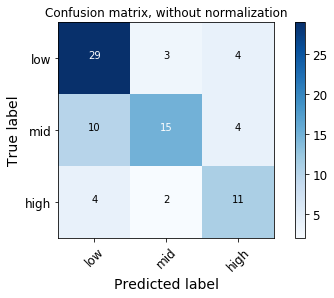

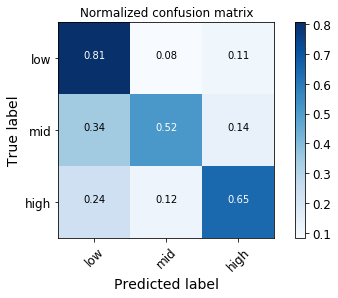

In [157]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_enm_only.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_enm_only.png')
plt.show()

In [158]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_enm = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_enm

0.6566185861317707

## 1:200 ENM-organics data

In [84]:
# TODO: Rerun with gamma_set=np.logspace(-6,0,6)
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(0,4,6)
gamma_set=np.logspace(-5,0,6)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_all+0.00001,bin_all)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 6.309573444801933, 'estimator__gamma': 1e-05}
0.49202969092236554


In [160]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=6.309573444801933, 
                      gamma=1e-05))
     ])
bestpipe.fit(X_all,bin_all)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=6.309573444801933, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[ 6 15 15]
 [ 5 11 13]
 [ 4  7  6]]
Normalized confusion matrix
[[0.17 0.42 0.42]
 [0.17 0.38 0.45]
 [0.24 0.41 0.35]]


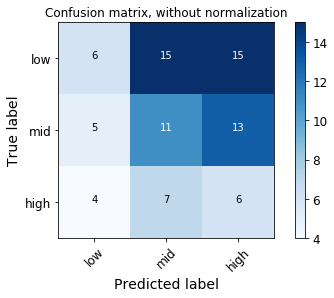

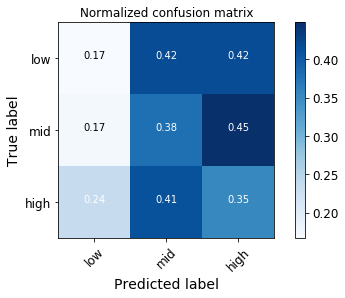

In [161]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_200.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_200.png')
plt.show()

In [124]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
avg_norm_oneto200 = (0.17+0.38+0.35)/3
avg_norm_oneto200

0.3

## 1:100 ENM-organics data

In [174]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(1,5,6)
gamma_set=np.logspace(-6,0,6)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_oneto100+0.00001,bin_oneto100)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 100000.0, 'estimator__gamma': 1.0}
0.7436609514609998


In [175]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=100000.0, 
                      gamma=1.0))
     ])
bestpipe.fit(X_oneto100,bin_oneto100)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[22 11  3]
 [ 7 19  3]
 [10  3  4]]
Normalized confusion matrix
[[0.61 0.31 0.08]
 [0.24 0.66 0.1 ]
 [0.59 0.18 0.24]]


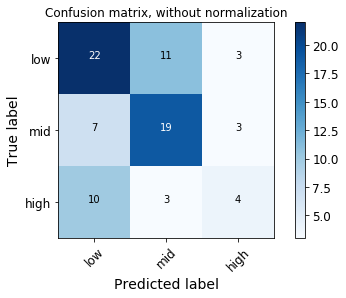

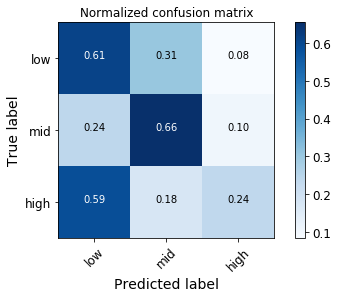

In [176]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_100.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_100.png')
plt.show()

In [177]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
avg_norm_oneto200 = (0.61+0.66+0.24)/3
avg_norm_oneto200

0.5033333333333333

## 1:50 ENM-organics data

In [178]:
# TODO: Run with parameter matrix 16x16

# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(1,5,10)
gamma_set=np.logspace(-6,0,10)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_oneto50+0.00001,bin_oneto50)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 100000.0, 'estimator__gamma': 1.0}
0.742467718794835


In [179]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=100000.0, 
                      gamma=1.0))
     ])
bestpipe.fit(X_oneto50,bin_oneto50)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[22 11  3]
 [ 7 19  3]
 [10  3  4]]
Normalized confusion matrix
[[0.61 0.31 0.08]
 [0.24 0.66 0.1 ]
 [0.59 0.18 0.24]]


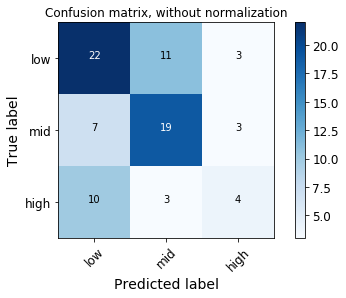

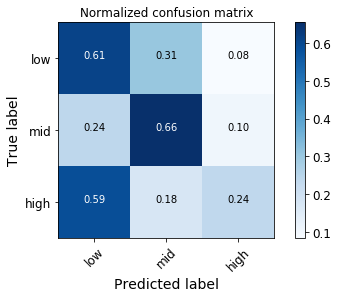

In [180]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_50.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_50.png')
plt.show()

In [181]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_oneto50 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_oneto50

0.5005258808504245

## 1:20 ENM-organics data

Ran with a slightly larger parameter grid for optimizing.

In [72]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(0,4,16)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_oneto20+0.00001,bin_oneto20)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 5411.6952654646375, 'estimator__gamma': 1.0}
0.6951219512195121


In [141]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=5411.6952654646375, 
                      gamma=1.0))
     ])
bestpipe.fit(X_oneto20,bin_oneto20)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=5411.6952654646375, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[22 11  3]
 [ 7 19  3]
 [10  3  4]]
Normalized confusion matrix
[[0.61 0.31 0.08]
 [0.24 0.66 0.1 ]
 [0.59 0.18 0.24]]


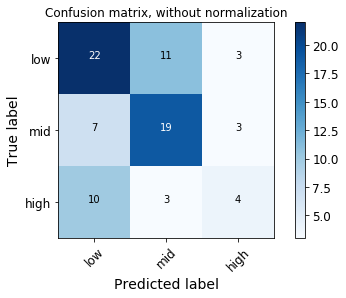

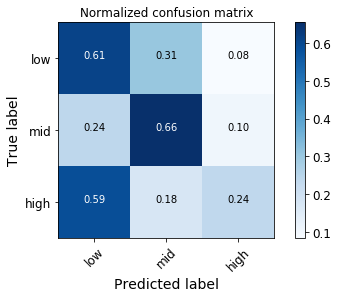

In [142]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_20.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_20.png')
plt.show()

In [143]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_oneto20 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_oneto20

0.5005258808504245

## 1:10 ENM-organics data

In [101]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(0,4,16)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_oneto10+0.00001,bin_oneto10)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 251.18864315095797, 'estimator__gamma': 1.0}
0.6851441241685144


In [144]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=251.18864315095797, 
                      gamma=1.0))
     ])
bestpipe.fit(X_oneto10,bin_oneto10)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=251.18864315095797, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[22 11  3]
 [ 7 19  3]
 [10  3  4]]
Normalized confusion matrix
[[0.61 0.31 0.08]
 [0.24 0.66 0.1 ]
 [0.59 0.18 0.24]]


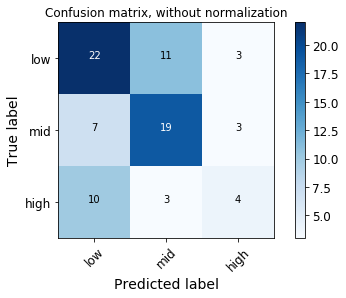

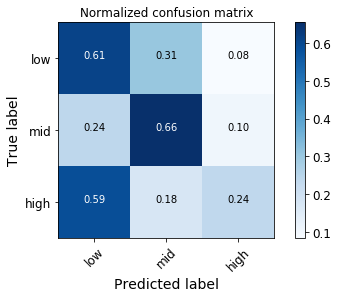

In [145]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_10.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_10.png')
plt.show()

In [146]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_oneto10 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_oneto10

0.5005258808504245

## 1:4 ENM-organics data

In [160]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(0,4,16)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_oneto4+0.00001,bin_oneto4)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 885.8667904100823, 'estimator__gamma': 1.0}
0.5878048780487805


In [164]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=1584.893192461114, 
                      gamma=0.003981071705534973))
     ])
bestpipe.fit(X_oneto4,bin_oneto4)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=1584.893192461114, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.003981071705534973,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[24  6  6]
 [ 7 18  4]
 [ 3  3 11]]
Normalized confusion matrix
[[0.67 0.17 0.17]
 [0.24 0.62 0.14]
 [0.18 0.18 0.65]]


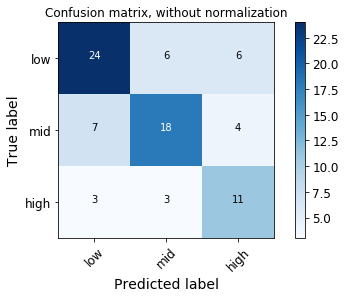

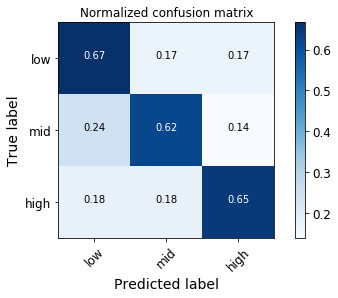

In [165]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_4.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_4.png')
plt.show()

In [166]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_oneto4 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_oneto4

0.6448050484561642

## 1:2 ENM-organics data

In [119]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3
c_set=np.logspace(0,4,16)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_oneto2+0.00001,bin_oneto2)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 135.93563908785256, 'estimator__gamma': 0.39810717055349776}
0.6382113821138211


In [120]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=6.309573444801933, 
                      gamma=1e-05))
     ])
bestpipe.fit(X_oneto2,bin_oneto2)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=6.309573444801933, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[ 6 15 15]
 [ 5 11 13]
 [ 4  7  6]]
Normalized confusion matrix
[[0.17 0.42 0.42]
 [0.17 0.38 0.45]
 [0.24 0.41 0.35]]


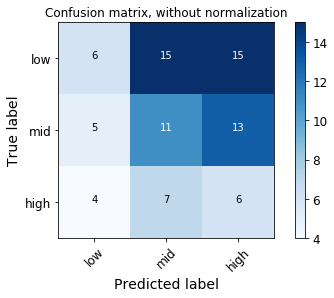

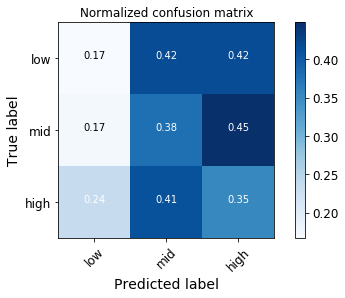

In [121]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_2.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_2.png')
plt.show()

In [122]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_oneto2 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_oneto2

0.2996393959882804

## Matching 1:20

In [127]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3

c_set=np.logspace(0,4,16)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match20+0.00001,bin_match20)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 2928.6445646252373, 'estimator__gamma': 1.0}
0.6608594657375145


In [128]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=grid_search.best_params_.get('estimator__C'), 
                      gamma=grid_search.best_params_.get('estimator__gamma')))
     ])
bestpipe.fit(X_match20,bin_match20)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=2928.6445646252373, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[22 11  3]
 [ 7 19  3]
 [10  3  4]]
Normalized confusion matrix
[[0.61 0.31 0.08]
 [0.24 0.66 0.1 ]
 [0.59 0.18 0.24]]


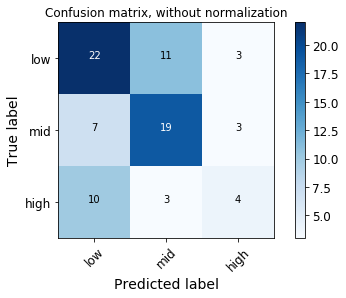

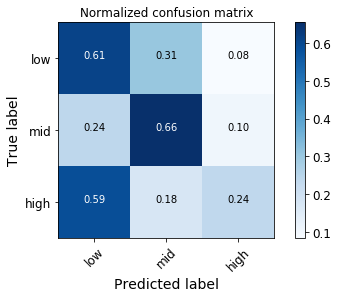

In [129]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match20.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match20.png')
plt.show()

In [130]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_match20 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_match20

0.5005258808504245

## Matching 1:10

In [141]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3

c_set=np.logspace(0,5,20)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match10+0.00001,bin_match10)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 8858.667904100823, 'estimator__gamma': 1.0}
0.6962305986696231


In [142]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=grid_search.best_params_.get('estimator__C'), 
                      gamma=grid_search.best_params_.get('estimator__gamma')))
     ])
bestpipe.fit(X_match10,bin_match10)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=8858.667904100823, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[22 11  3]
 [ 7 19  3]
 [10  3  4]]
Normalized confusion matrix
[[0.61 0.31 0.08]
 [0.24 0.66 0.1 ]
 [0.59 0.18 0.24]]


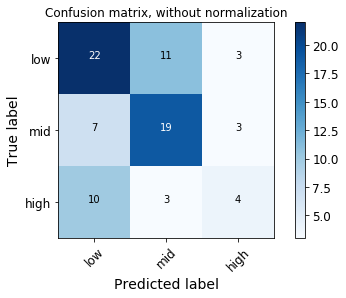

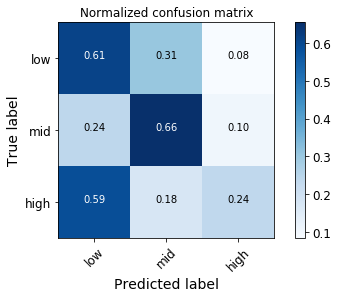

In [143]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match10.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match10.png')
plt.show()

In [144]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_match10 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_match10

0.5005258808504245

## Matching 1:5

In [162]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3

c_set=np.logspace(0,5,20)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match5+0.00001,bin_match5)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 3.3598182862837818, 'estimator__gamma': 0.01}
0.6036585365853658


In [163]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=grid_search.best_params_.get('estimator__C'), 
                      gamma=grid_search.best_params_.get('estimator__gamma')))
     ])
bestpipe.fit(X_match5,bin_match5)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=3.3598182862837818, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[31  3  2]
 [13  8  8]
 [ 5  3  9]]
Normalized confusion matrix
[[0.86 0.08 0.06]
 [0.45 0.28 0.28]
 [0.29 0.18 0.53]]


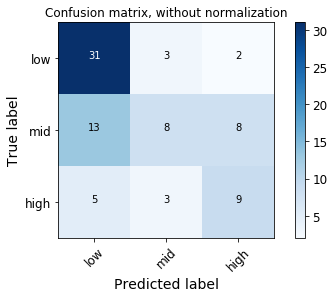

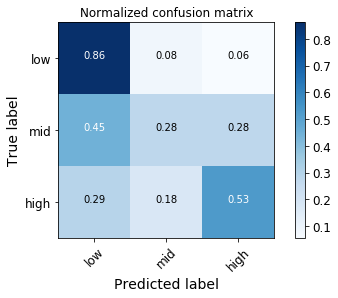

In [164]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match5.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match5.png')
plt.show()

In [165]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_match5 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_match5

0.5554616482608369

## Matching 1:4

In [220]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3

c_set=np.logspace(0,5,20)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match4+0.00001,bin_match4)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 16237.76739188721, 'estimator__gamma': 0.025118864315095822}
0.6390243902439025


In [221]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=grid_search.best_params_.get('estimator__C'), 
                      gamma=grid_search.best_params_.get('estimator__gamma')))
     ])
bestpipe.fit(X_match4,bin_match4)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=16237.76739188721, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.025118864315095822,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


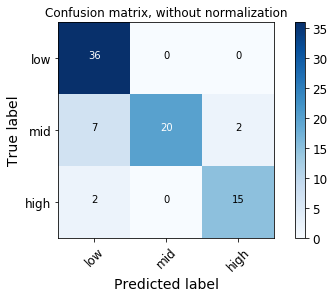

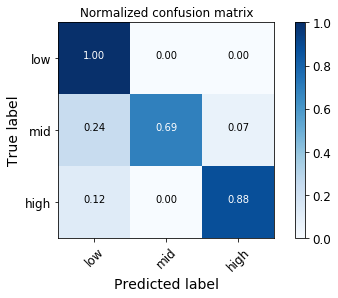

In [222]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match4.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match4.png')
plt.show()

In [223]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_match4 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_match4

0.8573360378634213

## Matching 1:3

In [216]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3

c_set=np.logspace(0,5,20)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match3+0.00001,bin_match3)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 11.28837891684689, 'estimator__gamma': 0.01}
0.7042682926829268


In [217]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=grid_search.best_params_.get('estimator__C'), 
                      gamma=grid_search.best_params_.get('estimator__gamma')))
     ])
bestpipe.fit(X_match3,bin_match3)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=11.28837891684689, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[34  0  2]
 [13  6 10]
 [ 5  0 12]]
Normalized confusion matrix
[[0.94 0.   0.06]
 [0.45 0.21 0.34]
 [0.29 0.   0.71]]


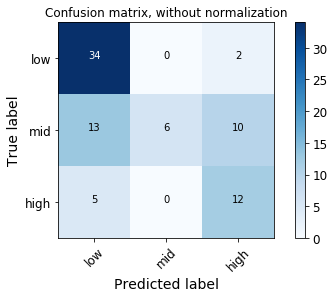

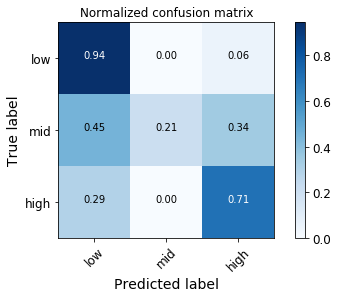

In [218]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match3.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match3.png')
plt.show()

In [219]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_match3 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_match3

0.6190744497032529

## Matching 1:2

In [207]:
# SVC-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Pipeline
estimator = SVC(kernel='rbf',class_weight='balanced')
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv=10
n_jobs=3

c_set=np.logspace(0,5,20)
gamma_set=np.logspace(-6,0,16)

# Gridsearch
param_grid={'estimator__C': c_set,
            'estimator__gamma': gamma_set
           }
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match2+0.00001,bin_match2)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__C': 29763.51441631319, 'estimator__gamma': 0.001584893192461114}
0.7357723577235772


In [213]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', SVC(kernel='rbf',class_weight='balanced', 
                      C=grid_search.best_params_.get('estimator__C'), 
                      gamma=grid_search.best_params_.get('estimator__gamma')))
     ])
bestpipe.fit(X_match2,bin_match2)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', SVC(C=29763.51441631319, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001584893192461114,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Confusion matrix, without normalization
[[36  0  0]
 [11 15  3]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.38 0.52 0.1 ]
 [0.12 0.   0.88]]


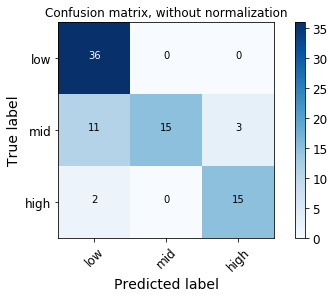

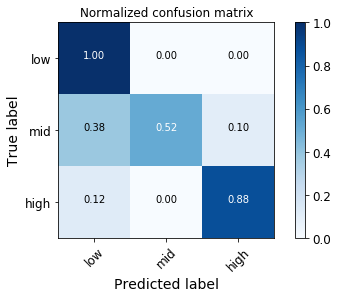

In [214]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match2.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match2.png')
plt.show()

In [215]:
# Calculate the normalized average accuracy
# for use in a graph of augmentation performance
cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
avg_norm_match2 = (cm_norm[0,0]+cm_norm[1,1]+cm_norm[2,2])/3
avg_norm_match2

0.7998647734956051

## Augmentation Performance

Using dataframes with different random states.

In [ ]:
augment = [('ENM-Organics_Ratio', ['1:200','1:100','1:50','1:20','1:10','1:4','1:2','1:0']),
           ('Percent_Organics',[100,50,25,10,5,2,1,0]),
          ('Avg_Norm_Performance', [avg_norm_oneto200,avg_norm_oneto100,avg_norm_oneto50,avg_norm_oneto20,avg_norm_oneto10,avg_norm_oneto4,avg_norm_oneto2,avg_norm_enm])]
augment_df = pd.DataFrame.from_list(augment)

In [224]:
augment_match = [('ENM-Organics_Ratio', ['1:200','1:20','1:10','1:5','1:4','1:3','1:2','1:0']),
           ('Percent_Organics_Used',[100,10,5,2.5,2,1.5,1,0]),
          ('Avg_Norm_Performance', [avg_norm_oneto200,avg_norm_match20,avg_norm_match10,avg_norm_match5,avg_norm_match4,avg_norm_match3,avg_norm_match2,avg_norm_enm])]
augment_match_df = pd.DataFrame.from_items(augment_match)
augment_match_df

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,ENM-Organics_Ratio,Percent_Organics_Used,Avg_Norm_Performance
0,1:200,100.0,0.503333
1,1:20,10.0,0.500526
2,1:10,5.0,0.500526
3,1:5,2.5,0.555462
4,1:4,2.0,0.857336
5,1:3,1.5,0.619074
6,1:2,1.0,0.799865
7,1:0,0.0,0.656619


# Random Forest Models

In [186]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Pipeline
estimator = RandomForestClassifier()
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv = 10
n_jobs = 3
n_set = [8,10,12,14,16,18,20,22,24,26]

# Gridsearch
param_grid={'estimator__n_estimators': n_set}
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_enm+0.00001,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__n_estimators': 20}
0.5853658536585366
accuracy


In [202]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Pipeline
estimator = RandomForestClassifier()
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv = 10
n_jobs = 3
n_set = [8,10,12,14,16,18,20,22,24,26,28,30,32]

# Gridsearch
param_grid={'estimator__n_estimators': n_set}
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match2+0.00001,bin_match2)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__n_estimators': 28}
0.6869918699186992
accuracy


In [205]:
grid_search.best_params_.get('estimator__n_estimators')

28

In [206]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', RandomForestClassifier(
        n_estimators = grid_search.best_params_.get('estimator__n_estimators')))
     ])
bestpipe.fit(X_match2,bin_match2)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
           ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


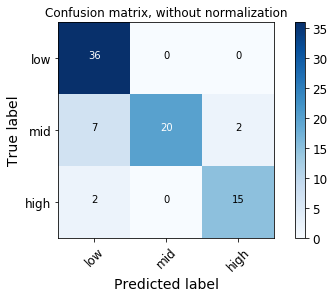

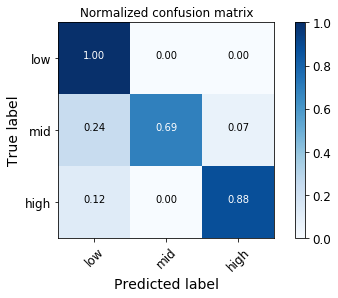

In [204]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#    bestpipe.fit(X_train,y_train)
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match2.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match2.png')
plt.show()